Q1

classify the Size_Categorie using SVM

Data:

month	month of the year: 'jan' to 'dec'
day	day of the week: 'mon' to 'sun'
FFMC	FFMC index from the FWI system: 18.7 to 96.20
DMC	DMC index from the FWI system: 1.1 to 291.3
DC	DC index from the FWI system: 7.9 to 860.6
ISI	ISI index from the FWI system: 0.0 to 56.10
temp	temperature in Celsius degrees: 2.2 to 33.30
RH	relative humidity in %: 15.0 to 100
wind	wind speed in km/h: 0.40 to 9.40
rain	outside rain in mm/m2 : 0.0 to 6.4
Size_Categorie 	the burned area of the forest ( Small , Large)

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.combine import SMOTETomek
from collections import Counter

In [2]:
data = pd.read_csv('forestfires.csv')
data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:
df = data.copy()
#remove dummies
df.drop(df.columns[11:30],axis=1,inplace = True)

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


<AxesSubplot:>

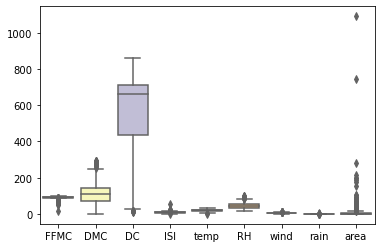

In [5]:
sns.boxplot(data=df, orient="v", palette="Set3") 
#outliers detected

Feature Analysis

In [6]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [7]:
df.size_category.value_counts()
#biased dataset

small    378
large    139
Name: size_category, dtype: int64

In [8]:
#using label encoding rather than dummy variables
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


In [9]:
#removing bias
#SMOTEK TECHNIQUE
resamp = df.copy()

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) 
#removed biasness from the dataset

Counter({'small': 378, 'large': 139})
Counter({'small': 371, 'large': 371})


In [10]:
# train split
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

C:\Users\amanu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

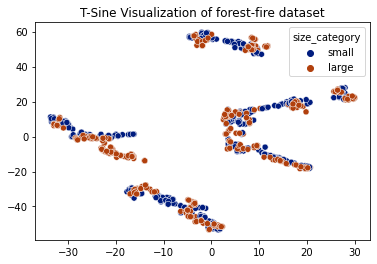

In [11]:
#visualization using dimensionality reduction(TSINE)
data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:,0],data_tsne_pca[:,1],hue=b, palette="dark").set_title('T-Sine Visualization of forest-fire dataset')

In [12]:
#SVM model
model = SVC(kernel='linear', C=1000)
model.fit(X_train, y_train)

SVC(C=1000, kernel='linear')

In [13]:
#model evaluation function

def report_model(model):
    model_preds = model.predict(X_test)
    print(confusion_matrix(y_test,model_preds))
    print(classification_report(y_test,model_preds))
    plot_confusion_matrix(model,X_test,y_test)

[[111   2]
 [  0 110]]
              precision    recall  f1-score   support

       large       1.00      0.98      0.99       113
       small       0.98      1.00      0.99       110

    accuracy                           0.99       223
   macro avg       0.99      0.99      0.99       223
weighted avg       0.99      0.99      0.99       223



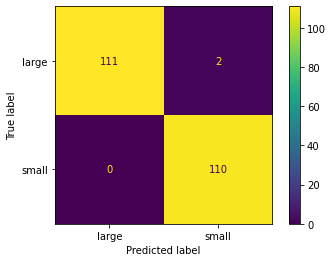

In [14]:
report_model(model)

[[ 83  30]
 [  0 110]]
              precision    recall  f1-score   support

       large       1.00      0.73      0.85       113
       small       0.79      1.00      0.88       110

    accuracy                           0.87       223
   macro avg       0.89      0.87      0.86       223
weighted avg       0.89      0.87      0.86       223



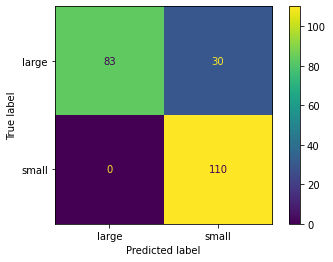

In [15]:
model1 = SVC(kernel='poly', C=100)
model1.fit(X_train, y_train)
report_model(model1)
#model performance reduced after reducing the C value

[[ 97  16]
 [  0 110]]
              precision    recall  f1-score   support

       large       1.00      0.86      0.92       113
       small       0.87      1.00      0.93       110

    accuracy                           0.93       223
   macro avg       0.94      0.93      0.93       223
weighted avg       0.94      0.93      0.93       223



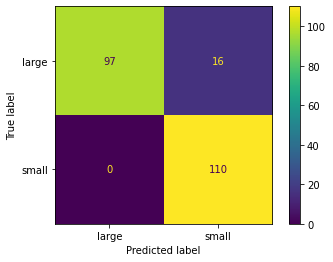

In [16]:
model2 = SVC(kernel='poly', C=1000)
model2.fit(X_train, y_train)
report_model(model2)
#model performance reduced in poly kernel

[[110   3]
 [  2 108]]
              precision    recall  f1-score   support

       large       0.98      0.97      0.98       113
       small       0.97      0.98      0.98       110

    accuracy                           0.98       223
   macro avg       0.98      0.98      0.98       223
weighted avg       0.98      0.98      0.98       223



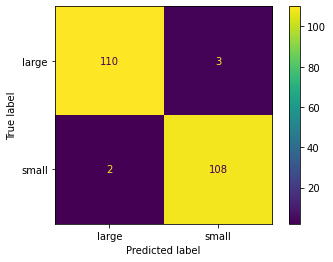

In [17]:
model3 = SVC(kernel='poly',gamma=0.5, C=1000)
model3.fit(X_train, y_train)
report_model(model3)

In [18]:
#using grid searchCV
grid_model = SVC()
param_grid = [{'kernel':['rbf','poly','linear','sigmoid'],'gamma':[50,5,10,0.5],'C':[1000,600,200,100,15,10,0.1,0.001] }]
gsv = GridSearchCV(grid_model,param_grid,cv=10)
gsv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [1000, 600, 200, 100, 15, 10, 0.1, 0.001],
                          'gamma': [50, 5, 10, 0.5],
                          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}])

In [19]:
gsv.best_params_ , gsv.best_score_ 

({'C': 1000, 'gamma': 50, 'kernel': 'linear'}, 0.9942307692307694)

[[111   2]
 [  0 110]]
              precision    recall  f1-score   support

       large       1.00      0.98      0.99       113
       small       0.98      1.00      0.99       110

    accuracy                           0.99       223
   macro avg       0.99      0.99      0.99       223
weighted avg       0.99      0.99      0.99       223



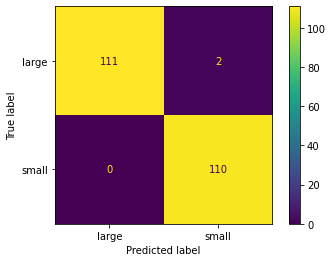

In [20]:
#final SVM model
model_fnl = SVC(kernel='linear',gamma=50, C=0.001)
model_fnl.fit(X_train, y_train)
report_model(model_fnl)

Q2

Prepare a classification model using SVM for salary data 

Data Description:

age -- age of a person
workclass	-- A work class is a grouping of work 
education	-- Education of an individuals	
maritalstatus -- Marital status of an individulas	
occupation	 -- occupation of an individuals
relationship -- 	
race --  Race of an Individual
sex --  Gender of an Individual
capitalgain --  profit received from the sale of an investment	
capitalloss	-- A decrease in the value of a capital asset
hoursperweek -- number of hours work per week	
native -- Native of an individual
Salary -- salary of an individual


In [21]:
data_train = pd.read_csv('SalaryData_Train(1).csv')
data_test = pd.read_csv('SalaryData_Test(1).csv')
data_train
data_test

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,Private,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
15056,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
15057,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
15058,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [22]:
df_train = data_train.copy()
df_test = data_test.copy()

In [23]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


,age,educationno,capitalgain,capitalloss,hoursperweek
count,30161.000000,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.438115,10.121316,1092.044064,88.302311,40.931269
std,13.134830,2.550037,7406.466611,404.121321,11.980182
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [24]:
#feature analysis
for x in range(1,len(df_train.columns)):
    print(df_train.iloc[:,x].value_counts())
    print('\n')
#highly biased

 Private             22285
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64


 HS-grad         9840
 Some-college    6677
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64


9     9840
10    6677
13    5044
14    1627
11    1307
7     1048
12    1008
6      820
4      557
15     542
5      455
8      377
16     375
3      288
2      151
1       45
Name: educationno, dtype: int64


 Married-civ-spouse       14065
 Never-married             9725
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent   

In [25]:
#label encoding
df_train.columns.values

array(['age', 'workclass', 'education', 'educationno', 'maritalstatus',
       'occupation', 'relationship', 'race', 'sex', 'capitalgain',
       'capitalloss', 'hoursperweek', 'native', 'Salary'], dtype=object)

In [26]:
label_encoder = preprocessing.LabelEncoder()
df_train.education= label_encoder.fit_transform(df_train.education) 
df_train.maritalstatus= label_encoder.fit_transform(df_train.maritalstatus) 
df_train.workclass= label_encoder.fit_transform(df_train.workclass) 
df_train.occupation= label_encoder.fit_transform(df_train.occupation) 
df_train.relationship= label_encoder.fit_transform(df_train.relationship) 
df_train.race= label_encoder.fit_transform(df_train.race) 
df_train.sex= label_encoder.fit_transform(df_train.sex) 
df_train.native= label_encoder.fit_transform(df_train.native) 
df_train.Salary= label_encoder.fit_transform(df_train.Salary) 
df_train

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,5,9,13,4,0,1,4,1,2174,0,40,37,0
1,50,4,9,13,2,3,0,4,1,0,0,13,37,0
2,38,2,11,9,0,5,1,4,1,0,0,40,37,0
3,53,2,1,7,2,5,0,2,1,0,0,40,37,0
4,28,2,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,27,2,7,12,2,12,5,4,0,0,0,38,37,0
30157,40,2,11,9,2,6,0,4,1,0,0,40,37,1
30158,58,2,11,9,6,0,4,4,0,0,0,40,37,0
30159,22,2,11,9,4,0,3,4,1,0,0,20,37,0


In [27]:
label_encoder = preprocessing.LabelEncoder()
df_test.education= label_encoder.fit_transform(df_test.education) 
df_test.maritalstatus= label_encoder.fit_transform(df_test.maritalstatus) 
df_test.workclass= label_encoder.fit_transform(df_test.workclass) 
df_test.occupation= label_encoder.fit_transform(df_test.occupation) 
df_test.relationship= label_encoder.fit_transform(df_test.relationship) 
df_test.race= label_encoder.fit_transform(df_test.race) 
df_test.sex= label_encoder.fit_transform(df_test.sex) 
df_test.native= label_encoder.fit_transform(df_test.native) 
df_test.Salary= label_encoder.fit_transform(df_test.Salary) 

<AxesSubplot:>

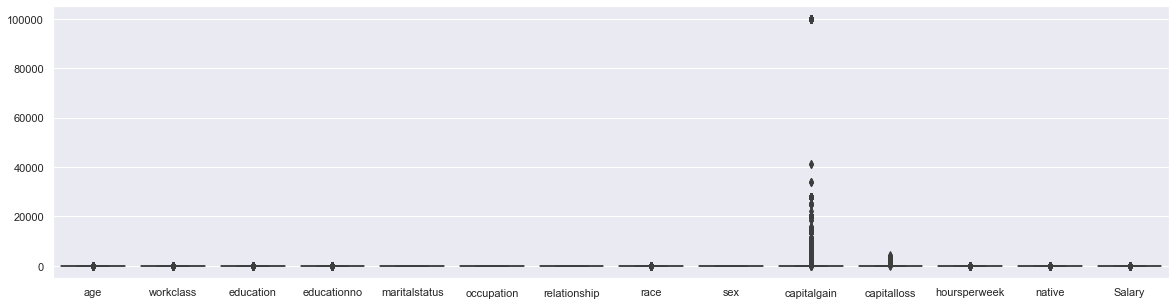

In [28]:
df_train.Salary.value_counts()
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df_train, palette="Set1") 
#outliers in capitalgain

In [29]:
#removing bias
#SMOTEK TECHNIQUE
resamp = df_train.copy()

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
m, n = smt.fit_resample(a, b)

#Count after
print(Counter(n)) #removed bias

Counter({0: 22653, 1: 7508})
Counter({0: 22236, 1: 22236})


In [30]:
# train split data
X_train =m
X_test = df_test.iloc[:,:-1]
y_train = n
y_test = df_test.iloc[:,-1] 

#data visualization using Tsine (dimesionality reduction)
#very slow to process (skip)
data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:,0],data_tsne_pca[:,1],hue=b, palette="dark").set_title('T-Sine Visualization of Salary dataset')

In [31]:
#SVM model
#model = SVC(kernel='linear', C=1000)
#model.fit(X_train, y_train)
#this thing taking forever.

In [32]:
#trying bagging classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [33]:
n_estimators = 10
model = OneVsRestClassifier(BaggingClassifier(LinearSVC(), max_samples=1.0 / n_estimators, n_estimators=n_estimators), n_jobs=-1)

In [34]:
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=LinearSVC(),
                                                max_samples=0.1),
                    n_jobs=-1)

In [35]:
def report_model(model):
    model_preds = model.predict(X_test)
    print(confusion_matrix(y_test,model_preds))
    print(classification_report(y_test,model_preds))
    plot_confusion_matrix(model,X_test,y_test)

[[10197  1163]
 [ 2157  1543]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     11360
           1       0.57      0.42      0.48      3700

    accuracy                           0.78     15060
   macro avg       0.70      0.66      0.67     15060
weighted avg       0.76      0.78      0.77     15060



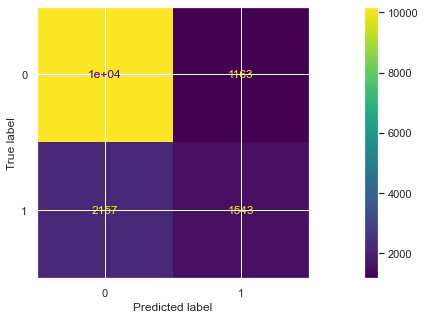

In [36]:
report_model(model)